# K-NearestNeighbour Sex Classification

## Initial Setup

### Imports

In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import os
import csv

from collections import OrderedDict
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from sklearn.cross_validation import LeaveOneOut, LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import DistanceMetric
from scipy.linalg import svd

%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

np.random.seed(12345678)  # for reproducibility, set random seed

### Getting File Lists

In [37]:
# Initializing dataset names
dataset_names = ['BNU1', 'BNU3', 'HNU1', 'KKI2009', 'NKI1', 'SWU4', 'Templeton114']
# only these dsets bc of available covariates

basepath = '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/'
# atlas = 'desikan'
dir_names = [basepath + '/' + d for d in dataset_names]

#  Crawls directories and creates a dictionary entry of file names for each
#  dataset which we plan to process.
fs = OrderedDict()
for idx, dd in enumerate(dataset_names):
    fs[dd] = [root + "/" + fl for root, dirs, files in os.walk(dir_names[idx])
              for fl in files if fl.endswith(".gpickle")]

ps = {os.path.splitext(os.path.basename(fl))[0] : root + "/" + fl
      for root, dirs, files in os.walk(basepath+'phenotypes')
      for fl in files if fl.endswith(".csv") }

print "Datasets: " + ", ".join([fkey + ' (' + str(len(fs[fkey])) + ')'
                                for fkey in fs])
print "Total Subjects: %d" % (sum([len(fs[key]) for key in fs]))


Datasets: BNU1 (114), BNU3 (47), HNU1 (300), KKI2009 (42), NKI1 (40), SWU4 (454), Templeton114 (114)
Total Subjects: 1111


In [38]:
ps

{'BNU1': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/BNU1.csv',
 'BNU3': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/BNU3.csv',
 'HNU1': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/HNU1.csv',
 'KKI2009': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/KKI2009.csv',
 'NKI1': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/NKI1.csv',
 'SWU4': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/SWU4.csv',
 'Templeton114': '/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud/phenotypes/Templeton114.csv'}

In [39]:
fs['BNU1'][0]

'/Users/gkiar/code/jhu/ocp/ndmg-paper/data/cloud//BNU1/sub-0025864_ses-1_dwi_desikan.gpickle'

### Declaring Graph Read Helper Functions

In [40]:
def loadGraphs(filenames, verb=False):
    """
    Given a list of files, returns a dictionary of graphs

    Required parameters:
        filenames:
            - List of filenames for graphs
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Initializes empty dictionary
    gstruct = OrderedDict()
    for idx, files in enumerate(filenames):
        if verb:
            print "Loading: " + files
        #  Adds graphs to dictionary with key being filename
        fname = os.path.basename(files)
        gstruct[fname] = nx.read_gpickle(files)
    return gstruct

def constructGraphDict(names, fs, verb=False):
    """
    Given a set of files and a directory to put things, loads graphs.

    Required parameters:
        names:
            - List of names of the datasets
        fs:
            - Dictionary of lists of files in each dataset
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Loads graphs into memory for all datasets
    graphs = OrderedDict()
    for idx, name in enumerate(names):
        if verb:
            print "Loading Dataset: " + name
        # The key for the dictionary of graphs is the dataset name
        graphs[name] = loadGraphs(fs[name], verb=verb)
    return graphs

### Reading Graphs

In [41]:
graphs = constructGraphDict(dataset_names, fs, verb=False)

### Reading Phenotypes

In [55]:
phenotypes = OrderedDict()
for dataset in dataset_names:
    tmp = csv.reader(open(ps[dataset]))
    pheno = OrderedDict()
    if dataset == 'KKI2009':
        triple = [[t[1].strip(), t[4], int(t[5] == 'M')] for t in tmp][1:]  # female=F->0, male=M->1
    elif dataset == 'Templeton114':
        triple = [[t[0].strip(), t[3], int(t[2] == '1')] for t in tmp][1:]  # female=0->0, male=1->1
    else:
        triple = [[t[0].strip(), t[2], int(t[3] == '2')] for t in tmp
                  if t[3] != '#' and t[2] != '#'][1:]  # female=1->0, male=2->1
    
    for idx, trip in enumerate(triple):
        pheno[trip[0]] = trip[1:]
    phenotypes[dataset] = pheno

### Converting Graphs to Vectors and Phenotypes to List

In [57]:
N = nx.number_of_nodes(graphs[graphs.keys()[0]][graphs[graphs.keys()[0]].keys()[0]])
feat = np.empty((0, int(sp.special.binom(N,2))), int)
dats = list(())
ages = np.array(())
sexy = np.array(())
sbjs = list(())


for idx1, dset in enumerate(graphs):
    print(dset)
    for idx2, subj in enumerate(graphs[dset]):
        A = nx.adjacency_matrix(graphs[dset][subj]).todense()
        Au = A[np.triu_indices(A.shape[0], 1)]
        feat = np.append(feat, Au, axis=0)
        dats.append(dset)

        try:
            subj_id = str(int(subj.split('-')[1].split('_')[0]))
        except:
            subj_id = subj.split('-')[1].split('_')[0]

        sbjs.append(subj_id)
#         print(subj_id)
        ages = np.append(ages, int(phenotypes[dset][subj_id][0]))
        sexy = np.append(sexy, int(phenotypes[dset][subj_id][1]))
print feat.shape, ages.shape, sexy.shape
print sum(sexy == 0), sum(sexy == 1)

BNU1
BNU3
HNU1
KKI2009
NKI1
SWU4
Templeton114
(1111, 2415) (1111,) (1111,)
562 549
['BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU1', 'BNU

---------

---------

## Classify Graphs

### KNN LOO Scan Cross Validation

In [58]:
c_mean_loo_scan = np.array(())
c_std_loo_scan = np.array(())
neighbourhoods = (np.arange(19)+2)*2-1
print "Neighbourhoods complete:",
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    loo = LeaveOneOut(len(sexy))
    score = cross_validation.cross_val_score(classif, feat, sexy, cv=loo)
    c_mean_loo_scan = np.append(c_mean_loo_scan, score.mean())
    c_std_loo_scan = np.append(c_std_loo_scan, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


### KNN LOO Subject Cross Validation

In [59]:
c_mean_loo_subj = np.array(())
c_std_loo_subj = np.array(())
print "Neighbourhoods complete:",
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    lolo = LeaveOneLabelOut(sbjs)
    score = cross_validation.cross_val_score(classif, feat, sexy, cv=lolo)
    c_mean_loo_subj = np.append(c_mean_loo_subj, score.mean())
    c_std_loo_subj = np.append(c_std_loo_subj, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


### KNN LOO Dataset

In [60]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

c_knn_loo_dsetx = np.array(())
c_knn_loo_dsety = np.array(())
for i in neighbourhoods:
    c_knn_loo_dsetx = np.append(c_knn_loo_dsetx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    c_knn_loo_dsety = np.append(c_knn_loo_dsety, knn[i])

### KNN LOO Dataset after subtracting cohort mean

In [61]:
feat_cm = np.copy(feat)
# print feat[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_cm[ind < 1] = updated
# print feat_cm[600]

In [62]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_cm[ind < 1] # current dataset is test
        ft_test = feat_cm[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

c_knn_loo_dset_cmx = np.array(())
c_knn_loo_dset_cmy = np.array(())
for i in neighbourhoods:
    c_knn_loo_dset_cmx = np.append(c_knn_loo_dset_cmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    c_knn_loo_dset_cmy = np.append(c_knn_loo_dset_cmy, knn[i])

### KNN LOO Dataset after subtracting population and then cohort means

In [63]:
pm = np.mean(feat, axis=0)
feat_pm = feat - pm

feat_pm_cm = np.copy(feat_pm)
# print feat_pm[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_pm_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_pm_cm[ind < 1] = updated
# print feat_pm_cm[600]

In [64]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_pm_cm[ind < 1] # current dataset is test
        ft_test = feat_pm_cm[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

c_knn_loo_dset_pmcmx = np.array(())
c_knn_loo_dset_pmcmy = np.array(())
for i in neighbourhoods:
    c_knn_loo_dset_pmcmx = np.append(c_knn_loo_dset_pmcmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    c_knn_loo_dset_pmcmy = np.append(c_knn_loo_dset_pmcmy, knn[i])

### KNN LOO Dataset after normalizing data

In [65]:
feat_un = normalize(feat)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [66]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_un[ind < 1] # current dataset is test
        ft_test = feat_un[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f" % (score)
    knn[i] = tmp

c_knn_loo_dset_unx = np.array(())
c_knn_loo_dset_uny = np.array(())
for i in neighbourhoods:
    c_knn_loo_dset_unx = np.append(c_knn_loo_dset_unx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    c_knn_loo_dset_uny = np.append(c_knn_loo_dset_uny, knn[i])

---------

---------

## Save the things

In [68]:
result_file1 = basepath + '/classification_results.npz'
np.savez(result_file1,
         neighbourhoods=neighbourhoods,
         c_mean_loo_scan=c_mean_loo_scan, c_std_loo_scan=c_std_loo_scan,
         c_mean_loo_subj=c_mean_loo_subj, c_std_loo_subj=c_std_loo_subj,
         c_knn_loo_dsetx=c_knn_loo_dsetx, c_knn_loo_dsety=c_knn_loo_dsety,
         c_knn_loo_dset_cmx=c_knn_loo_dset_cmx, c_knn_loo_dset_cmy=c_knn_loo_dset_cmy,
         c_knn_loo_dset_pmcmx=c_knn_loo_dset_pmcmx, c_knn_loo_dset_pmcmy=c_knn_loo_dset_pmcmy,
         c_knn_loo_dset_unx=c_knn_loo_dset_unx, c_knn_loo_dset_uny=c_knn_loo_dset_uny)

feature_file = basepath + '/classified_vectors.npz'
np.savez(feature_file,
         ages=ages,
         sexy=sexy,
         sbjs=sbjs,
         feat=feat,
         feat_cm=feat_cm,
         feat_pm_cm=feat_pm_cm,
         feat_un=feat_un)

---------

---------

## Load the things

In [69]:
feature_file = basepath + '/classified_vectors.npz'
result_file1 = basepath + '/classification_results.npz'

In [71]:
from numpy import array
dat = np.load(feature_file)
dat.files
d2 = np.load(result_file1)
for key in d2:
    exec('{KEY} = {VALUE}'.format(KEY = key, VALUE = repr(d2[key]))) 

--------

--------
## Plotting

In [74]:
c_knn_loo_dsetx = np.floor(c_knn_loo_dsetx)
c_knn_loo_dset_cmx = np.floor(c_knn_loo_dset_cmx)
c_knn_loo_dset_pmcmx= np.floor(c_knn_loo_dset_pmcmx)
c_knn_loo_dset_unx = np.floor(c_knn_loo_dset_unx)

c_mean_loo_dset = np.array(())
c_std_loo_dset = np.array(())

c_mean_loo_dset_cm = np.array(())
c_std_loo_dset_cm = np.array(())

c_mean_loo_dset_pmcm = np.array(())
c_std_loo_dset_pmcm = np.array(())

c_mean_loo_dset_un = np.array(())
c_std_loo_dset_un = np.array(())

for idx in neighbourhoods:
    tmp = c_knn_loo_dsety[c_knn_loo_dsetx == idx]
#     print len(tmp)
    c_mean_loo_dset = np.append(c_mean_loo_dset, np.mean(tmp))
    c_std_loo_dset = np.append(c_std_loo_dset, np.std(tmp))
    
    tmp_cm = c_knn_loo_dset_cmy[c_knn_loo_dset_cmx == idx]
#     print len(tmp_cm)
    c_mean_loo_dset_cm = np.append(c_mean_loo_dset_cm, np.mean(tmp_cm))
    c_std_loo_dset_cm = np.append(c_std_loo_dset_cm, np.std(tmp_cm))

    tmp_pmcm = c_knn_loo_dset_pmcmy[c_knn_loo_dset_pmcmx == idx]
#     print len(tmp_pmcm)
    c_mean_loo_dset_pmcm = np.append(c_mean_loo_dset_pmcm, np.mean(tmp_pmcm))
    c_std_loo_dset_pmcm = np.append(c_std_loo_dset_pmcm, np.std(tmp_pmcm))
    
    tmp_pmcm = c_knn_loo_dset_uny[c_knn_loo_dset_unx == idx]
#     print len(tmp_pmcm)
    c_mean_loo_dset_un = np.append(c_mean_loo_dset_un, np.mean(tmp_pmcm))
    c_std_loo_dset_un = np.append(c_std_loo_dset_un, np.std(tmp_pmcm))
    
print len(c_std_loo_dset_cm), len(c_mean_loo_dset_cm),
print len(c_std_loo_dset_pmcm), len(c_mean_loo_dset_pmcm), len(c_mean_loo_dset_un)

19 19 19 19 19


In [138]:
import colorlover as cl
from IPython.display import HTML

types = ['Chance', 'LOO Session', 'LOO Subj', 'LOO Dataset',
         'LOO Dataset (-CM)', 'LOO Dataset (-PM-CM)', 'LOO Dataset (UN)']

#sequential orange-red 10
cols = cl.scales['6']['seq']['YlOrBr'][5::-1]#.keys()

print(cols)
cols2 = OrderedDict()
cols2[types[0]] = 'rgb(100,100,100)'
cols2[types[1]] = 'rgb(38, 205, 111)'
cols2[types[2]] = 'rgb(51,160,44)'
# cols2[types[3]] = 'rgb(185, 0, 50)'
# cols2[types[4]] = 'rgb(246, 51, 0)'
for idx, d in enumerate(types[3:]):
    cols2[d] = cols[idx]
cols = cols2
HTML(cl.to_html(cols.values()))
cols_list = cols.values()
# HTML(cl.to_html(cols))

['rgb(153,52,4)', 'rgb(217,95,14)', 'rgb(254,153,41)', 'rgb(254,196,79)', 'rgb(254,227,145)', 'rgb(255,255,212)']


In [139]:
cols_list = cl.to_numeric(cols_list)
cols_list = [tuple([cpit/255 for cpit in cthing]) for cthing in cols_list]

In [ ]:
import ndmg.stats.plotly_helper as plh
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.graph_objs import *

init_notebook_mode()



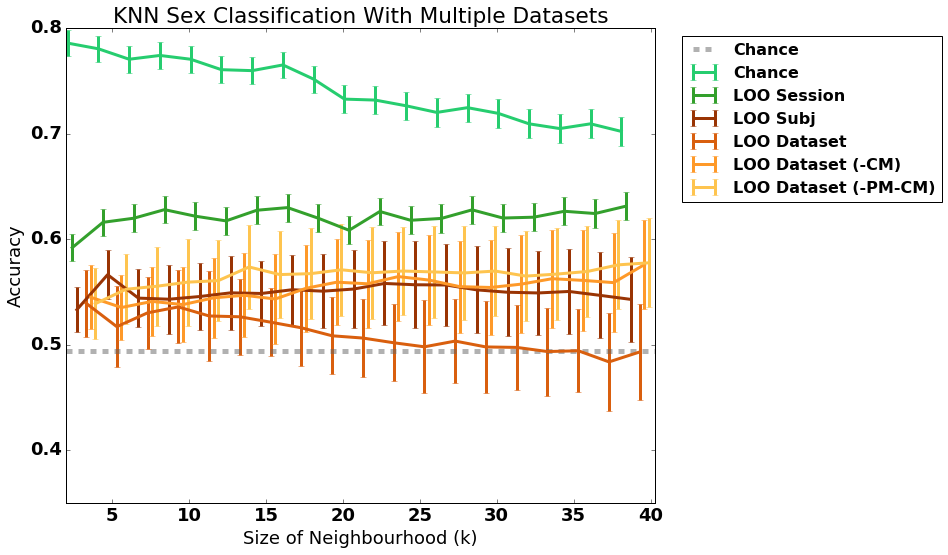

In [140]:
fig = plt.figure(figsize=(1.2*8,8))
plt.errorbar(neighbourhoods-0.9, c_mean_loo_scan, c_std_loo_scan/np.sqrt(len(sexy)), lw=3, color=cols_list[1]) #'#00ee00')
plt.errorbar(neighbourhoods-0.6, c_mean_loo_subj, c_std_loo_subj/np.sqrt(len(sexy)), lw=3, color=cols_list[2]) #'#ee0000')
plt.hold(True)
plt.axhline(sum(sexy)/len(sexy), linestyle='--', lw=5, alpha=0.5, color=cols_list[0]) #"#0000ee")
plt.errorbar(neighbourhoods-0.3, c_mean_loo_dset, c_std_loo_dset/np.sqrt(len(dataset*1)), lw=3, color=cols_list[3]) #'#000000')
plt.errorbar(neighbourhoods+0.3, c_mean_loo_dset_cm, c_std_loo_dset_cm/np.sqrt(len(dataset*1)), lw=3, color=cols_list[4]) #'#ee00ee')
plt.errorbar(neighbourhoods+0.6, c_mean_loo_dset_pmcm, c_std_loo_dset_pmcm/np.sqrt(len(dataset*1)), lw=3, color=cols_list[5]) #'#eeee00')
plt.errorbar(neighbourhoods+0.9, c_mean_loo_dset_un, c_std_loo_dset_un/np.sqrt(len(dataset*1)), lw=3, color=cols_list[6]) #'#606060')

# plt.ylim((0.5, 0.7))
# plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
plt.xlim([2, 40.3])
plt.ylim([0.35, 0.8])
plt.xlabel('Size of Neighbourhood (k)')
plt.ylabel('Accuracy')
plt.title('KNN Sex Classification With Multiple Datasets')
lgd = plt.legend(['Chance'] + types,
                 fontsize=16, bbox_to_anchor = (1.5, 1))
plt.tight_layout(1)
plt.savefig(basepath + 'classification_desikan.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()